# Movie Reviews Sentiment Analysis (MRSA)

- Version: 1
- Date: 9 February 2017

This is a simple POC project to model a sentiment analysis machine learning using text-mining. Using a Movie Reviews as the case. For the machine learning algorithm I just used Multinomial Naive Bayes (MultinomialNB), which is generaly used as base line algorithm for Text-Mining and suit to it as well.

* Dataset for training can be obtained [Here](https://goo.gl/BQIbGv)
* Some reference regarding to working with text data classification in Python Scikit-Learn [Here](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

## Import Libraries

In [1]:
import glob
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

# to save/load trained model
from sklearn.externals import joblib

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Load Dataset

### Load & Explor Positive Review Dataset

In [2]:
list_pos = []
allFiles_pos = glob.glob('movie/pos/*.txt')
for file in allFiles_pos:
    rfile = open(file, 'r')
    list_pos.append(rfile.read())                                                                           

In [3]:
train_pos = pd.DataFrame(list_pos,columns=['message'])
train_pos['label'] = 1

In [4]:
def fixMessage(row):
    s = row['message'].replace("\n","")
    return s.replace("\'","")

In [5]:
train_pos['message'] = train_pos.apply(lambda r: fixMessage(r),axis=1)

#### Preview Positive Data & Shape

In [6]:
train_pos.head()

,message,label
0,dark city is such a rare treat : it ? s a stun...,1
1,_in brief : _ this film needs no introduction ...,1
2,every once in a while you see a film that is s...,1
3,plot : a big-time mommas boy cant seem to leav...,1
4,wow ! what a movie . its everything a movie ca...,1


In [7]:
train_pos.shape

(1000, 2)

In [8]:
train_pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
message    1000 non-null object
label      1000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.7+ KB


### Load & Explor Negative Review Dataset

In [9]:
list_neg = []
allFiles_neg = glob.glob('movie/neg/*.txt')
for file in allFiles_neg:
    rfile = open(file, 'r')
    list_neg.append(rfile.read()) 

In [10]:
train_neg = pd.DataFrame(list_neg,columns=['message'])
train_neg['label'] = 0

In [11]:
train_neg['message'] = train_neg.apply(lambda r: fixMessage(r),axis=1)

#### Preview Negative Data & Shape

In [12]:
train_neg.head()

,message,label
0,"tri-star ; rated r ( language , sexual situati...",0
1,""" from the director of "" the nightmare before...",0
2,if youre into watching near on two hours of bo...,0
3,""" what is this , a homicide or a bad b-movie ...",0
4,"this feature is like a double header , two set...",0


In [13]:
train_neg.shape

(1000, 2)

In [14]:
train_neg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
message    1000 non-null object
label      1000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.7+ KB


### Combine Positive & Negative Data

In [15]:
train = pd.concat([train_pos,train_neg])
train.reset_index(drop=True,inplace=True)

In [16]:
# optional save to csv
#train.to_csv('imdb_train.csv',index=False)

In [17]:
train.head()

,message,label
0,dark city is such a rare treat : it ? s a stun...,1
1,_in brief : _ this film needs no introduction ...,1
2,every once in a while you see a film that is s...,1
3,plot : a big-time mommas boy cant seem to leav...,1
4,wow ! what a movie . its everything a movie ca...,1


In [18]:
train.shape

(2000, 2)

In [19]:
train.describe()

,label
count,2000.000000
mean,0.500000
std,0.500125
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
message    2000 non-null object
label      2000 non-null int64
dtypes: int64(1), object(1)
memory usage: 31.3+ KB


In [21]:
train.groupby('label').describe()

message
label                                                          
0     count                                                1000
      unique                                               1000
      top     fact that charles bronson represents one of th...
      freq                                                    1
1     count                                                1000
      unique                                               1000
      top     seen may 31 , 1999 on home video ( rented ) . ...
      freq                                                    1

In [22]:
train['length'] = train['message'].apply(len)
train.head()

,message,label,length
0,dark city is such a rare treat : it ? s a stun...,1,3602
1,_in brief : _ this film needs no introduction ...,1,7434
2,every once in a while you see a film that is s...,1,4240
3,plot : a big-time mommas boy cant seem to leav...,1,4070
4,wow ! what a movie . its everything a movie ca...,1,4182


### Checking Data Distribution with Data Visualization

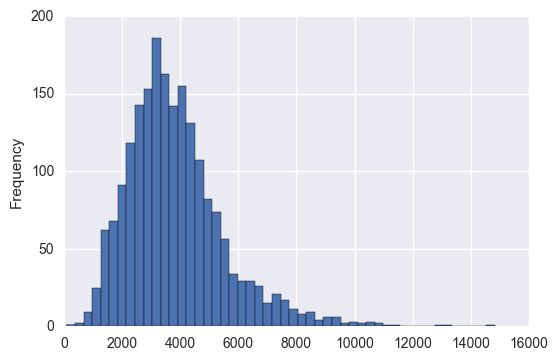

In [23]:
train['length'].plot(bins=50, kind='hist') 

In [24]:
train.length.describe()

count     2000.000000
mean      3845.329500
std       1693.935555
min         89.000000
25%       2706.000000
50%       3576.500000
75%       4656.500000
max      14821.000000
Name: length, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f15ff232780>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f15ff182048>], dtype=object)

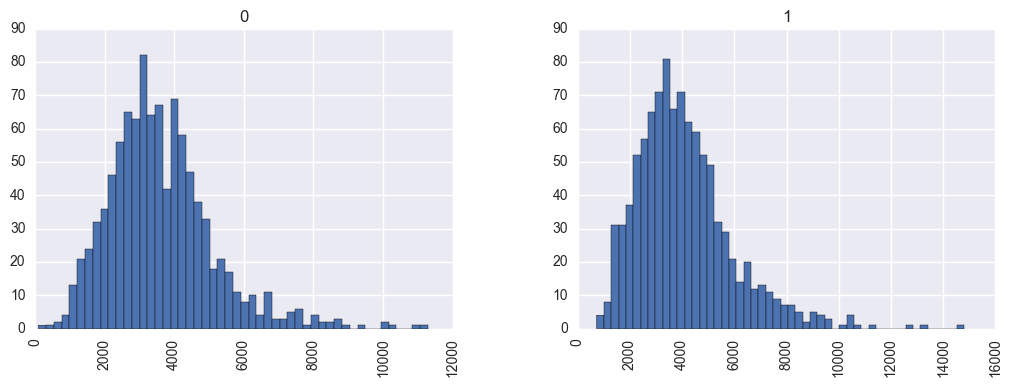

In [25]:
train.hist(column='length', by='label', bins=50,figsize=(12,4))

## Preparing Data for Transformation & Training Model

### preparing data for Count Vectorizer
The ease the process all step for Counte Vectorizer will combine in single function: **text_process**

In [26]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """    
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

### Split the Dataset for Train & Test

In [27]:
x_train,x_test,y_train,y_test = train_test_split(train['message'], train['label'], test_size=0.34, random_state=101 )

#### Checking generated label for train dataset class imballance

In [28]:
y_train.value_counts()

1    665
0    655
Name: label, dtype: int64

## Building the MultinomialNB Model

Using Scikit-Learn pipeline to ease the process flow.

In [29]:
multinomialNB_pipe = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

In [30]:
multinomialNB_pipe.fit(x_train,y_train)

Pipeline(steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x7f15fee099d8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=No...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [31]:
multinomialNB_pred = multinomialNB_pipe.predict(x_test)

#### Review model with Confussion Matrix

In [32]:
print(classification_report(multinomialNB_pred,y_test))

             precision    recall  f1-score   support

          0       0.82      0.84      0.83       334
          1       0.84      0.82      0.83       346

avg / total       0.83      0.83      0.83       680



## Evaluation Testing
Here I have some manually comment for testing purpose.

In [33]:
comment = ["Really very good movie I ever watched!!!", # pos
           "I would rather go home than watch this movie.", # neg
           "what's the movie! give me back my money!!!", # neg
           "the movie is so great! i love the action scene of the movie.", #pos
           "I like the movie, but the ending is not good, hope there're more supprised point.", #neg
           "The best film of the year to date, ambitious in conception and extraordinary in execution, has arrived.", # pos
           "At least this is the last time we're ever going to see terrible excuse of wasting your money, but if it isn't, then stop, Paul W.S. Anderson.", #neg
           "Good movie very enjoyable with popcorn.", #pos
           "Enjoyed the final third. Wasn't a big fan of Whitaker or Jones in this film. Overall, a solid blockbuster action flick.", #pos
           "Did not feel like it's a good movie... the tiny cameos did not make the movie worth watching. It was boring & only had a few good moments."] #neg
mytest = pd.Series(data=comment)

In [34]:
mypred = multinomialNB_pipe.predict(mytest)

In [35]:
mypred

array([1, 0, 0, 0, 0, 1, 0, 1, 1, 0])

From the 10 comments, we only miss 1 prediction (4th comment), not bad huh? 

## Save Model Instance for Production

In [36]:
filename = 'movieSA-MNNB.sav'
joblib.dump(multinomialNB_pipe, filename)
print('Saving model to file done!')

Saving model to file done!
